In [1]:
import tensorflow as tf
import numpy

2023-07-11 13:15:11.472596: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-11 13:15:11.474331: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-11 13:15:11.511087: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-11 13:15:11.511964: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 13:15:12.130701: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpg
import cv2
import os
import zipfile
from tensorflow.keras.layers import Conv2D,Conv2DTranspose, Dense, Flatten, Input,BatchNormalization,PReLU,LeakyReLU,Concatenate,ReLU,UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.nn import depth_to_space
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.math import reduce_mean,square
from tensorflow.keras.losses import MeanSquaredError,BinaryCrossentropy
from tensorflow.keras import Sequential

In [3]:
def residual_blocks(input):
  x = Conv2D(64,(3,3),padding='same')(input)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = Conv2D(64,(3,3),padding='same')(x)
  x = BatchNormalization()(x)
  x = Concatenate()([input,x])
  return x

def subpixel(input):
  x = UpSampling2D()(input)
  x = Conv2D(256,(3,3),padding='same')(x)
  x = ReLU()(x)
  return x

def generator():
  inputs = Input(shape=(96,96,3))
  x1 = Conv2D(64,(9,9),padding='same')(inputs)
  x1 = ReLU()(x1)
  r = residual_blocks(x1)
  for _ in range(15):
    r = residual_blocks(r)
  x2 = Conv2D(64,(3,3),padding='same')(r)
  x2 = BatchNormalization()(x2)
  merge = Concatenate()([x2,x1])

  x = subpixel(merge)
  x = subpixel(x)
  output = Conv2D(3,(9,9),padding='same',activation='sigmoid')(x)


  model = Model(inputs,output)
  return model


In [4]:
g_model = generator()
g_model.summary()

2023-07-11 13:15:13.203886: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 96, 96, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 re_lu (ReLU)                   (None, 96, 96, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 96, 64)   36928       ['re_lu[0][0]']                  
                                                                                              

                                                                                                  
 conv2d_11 (Conv2D)             (None, 96, 96, 64)   221248      ['concatenate_4[0][0]']          
                                                                                                  
 batch_normalization_10 (BatchN  (None, 96, 96, 64)  256         ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_6 (ReLU)                 (None, 96, 96, 64)   0           ['batch_normalization_10[0][0]'] 
                                                                                                  
 conv2d_12 (Conv2D)             (None, 96, 96, 64)   36928       ['re_lu_6[0][0]']                
                                                                                                  
 batch_nor

 conv2d_22 (Conv2D)             (None, 96, 96, 64)   36928       ['re_lu_11[0][0]']               
                                                                                                  
 batch_normalization_21 (BatchN  (None, 96, 96, 64)  256         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 concatenate_10 (Concatenate)   (None, 96, 96, 768)  0           ['concatenate_9[0][0]',          
                                                                  'batch_normalization_21[0][0]'] 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 96, 96, 64)   442432      ['concatenate_10[0][0]']         
                                                                                                  
 batch_nor

 conv2d_33 (Conv2D)             (None, 96, 96, 64)   626752      ['concatenate_15[0][0]']         
                                                                                                  
 batch_normalization_32 (BatchN  (None, 96, 96, 64)  256         ['conv2d_33[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 concatenate_16 (Concatenate)   (None, 96, 96, 128)  0           ['batch_normalization_32[0][0]', 
                                                                  're_lu[0][0]']                  
                                                                                                  
 up_sampling2d (UpSampling2D)   (None, 192, 192, 12  0           ['concatenate_16[0][0]']         
                                8)                                                                
          

In [5]:
plot_model(g_model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [6]:
def conv_block(input,n_channels):
  x = Conv2D(n_channels,(3,3),padding='same')(input)
  x = BatchNormalization()(x)
  x = LeakyReLU(0.2)(x)
  x = Conv2D(n_channels,(3,3),padding='same',strides=(2,2))(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(0.2)(x)
  return x


def discriminator():
  input = Input(shape=(384,384,3))
  c1 = Conv2D(64,(3,3),padding='same')(input)
  c1 = LeakyReLU(0.2)(c1)
  c1 = Conv2D(64,(3,3),padding='same',strides=(2,2))(c1)
  c1 = BatchNormalization()(c1)
  c1 = LeakyReLU(0.2)(c1)
  c2 = conv_block(c1,128)
  c3 = conv_block(c2,256)
  c4 = conv_block(c3,512)
  x = Flatten()(c4)
  x = Dense(1024)(x)
  x = LeakyReLU(0.2)(x)
  output = Dense(1,activation='sigmoid')(x)
  model = Model([input],output)
  return model

In [7]:
d_model = discriminator()
d_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 384, 384, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 384, 384, 64)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 192, 192, 64)      36928     
                                                                 
 batch_normalization_33 (Bat  (None, 192, 192, 64)     256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 192, 192, 64)      0         
                                                           

In [8]:
plot_model(d_model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [9]:

def vgg_model():
  selected_layers = ['block3_conv4' ]
  vgg_model = VGG19(include_top=False,
                    input_shape=(384,384,3))
  for layers in vgg_model.layers:
    layers.trainable = False
  model = Model(vgg_model.input,outputs=[vgg_model.get_layer(layer).output for layer in selected_layers])
  model.trainable = False
  return model

vgg_model = vgg_model()
vgg_model.summary()

vgg_model.trainable

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 384, 384, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 384, 384, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 192, 192, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 192, 192, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 192, 192, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 96, 96, 128)       0   

False

In [10]:
from tensorflow import add,dtypes
crossEntropy = BinaryCrossentropy()
mse = MeanSquaredError()
def discriminator_loss(real_output,fake_output,batch_size):
  valid = np.ones((batch_size,1))
  fake = np.zeros((batch_size,1))
  real_loss = crossEntropy(valid,real_output)
  fake_loss = crossEntropy(fake,fake_output)
  total_loss = 0.5*(real_loss + fake_loss)
  return total_loss

def generator_loss(generated_image,real_hr,batch_size):
  fake_image_features = vgg_model(generated_image)
  real_image_features = vgg_model(real_hr)
  vgg_loss = mse(fake_image_features,real_image_features)
  vgg_loss = dtypes.cast(vgg_loss,tf.float64)
  d_out_fake = d_model(generated_image)
  gan_loss = (1e-3)*crossEntropy(d_out_fake,np.ones((batch_size,1)))
  total_loss = add(gan_loss,vgg_loss)
  return total_loss


In [11]:
data = zipfile.ZipFile('new_dataset.zip')
data.extractall()
data.close()

In [12]:

lr_path = 'finished/train/dataraw/hires'
hr_path = 'finished/train/dataraw/hires'

lr = []
for image in sorted(os.listdir(lr_path)):
  img_path = os.path.join(lr_path,image)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(96,96))
  img = (img/255)
  img = img.astype('float32')
  lr.append(img)

hr =[]
for image in sorted(os.listdir(hr_path)):
  img_path = os.path.join(hr_path,image)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
  img = cv2.resize(img,(384,384))
  img = (img/255)
  img = img.astype('float32')

  hr.append(img)

In [13]:
lr[0].shape,hr[0].shape
type(lr[0])

numpy.ndarray

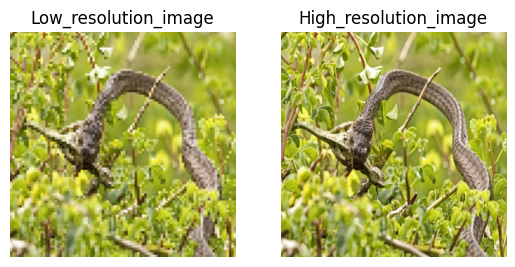

In [14]:

plt.subplot(1,2,1)
plt.imshow(lr[10])
plt.axis('off')
plt.title("Low_resolution_image")

plt.subplot(1,2,2)
plt.imshow(hr[10])
plt.axis('off')
plt.title("High_resolution_image")

plt.show()

In [15]:
lr = np.reshape(lr,(len(lr),96,96,3))
hr = np.reshape(hr,(len(hr),384,384,3))
lr.shape,hr.shape

((4128, 96, 96, 3), (4128, 384, 384, 3))

In [ ]:
from tensorflow import GradientTape,function
generator_optimizer = Adam(learning_rate=0.0001,beta_1=0.9)
discriminator_optimizer = Adam(learning_rate=0.0001,beta_1=0.9)


@tf.function
def train_step(lr_images,hr_images,n_samples):
  with GradientTape() as disc_tape:
    generated_images = g_model(lr_images,training=True)
    real_output = d_model(hr_images,training=True)
    fake_output = d_model(generated_images,training=True)
    d_loss = discriminator_loss(real_output,fake_output,n_samples)
  gradients_of_discriminator = disc_tape.gradient(d_loss, d_model.trainable_variables)
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, d_model.trainable_variables))

  with tf.GradientTape() as gen_tape:
    fake_output = g_model(lr_images)
    g_loss = generator_loss(fake_output, hr_images,n_samples)

  gradients_of_generator = gen_tape.gradient(g_loss, g_model.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, g_model.trainable_variables))

  return d_loss,g_loss

def train(lr_images,hr_images,epochs=50,n_samples=5):
  samples = np.array([1,2,3,4,5])
  for epoch in range(epochs):
    for batch in range(int(4128//5)-1):
        input_lr = lr[samples]
        input_hr = hr[samples]
        samples+=5
        d_loss,g_loss = train_step(input_lr,input_hr,n_samples)
        samples+=1
        print(f'Epoch: {epoch+1} - {batch+1}/{int(4128//5)} - - {d_loss},{g_loss}')
    if epoch%10 == 0:
        file_name = 'generator_model'+str(epoch)+'.h5'
        g_model.save(file_name)
        
train(lr,hr)
















Epoch: 1 - 1/825 - - 0.7466749548912048,87.8358766911177
Epoch: 1 - 2/825 - - 5.64156436920166,105.76620838914305
Epoch: 1 - 3/825 - - 29.44089126586914,112.29445964082423
Epoch: 1 - 4/825 - - 11.65610122680664,113.28321063377487
Epoch: 1 - 5/825 - - 1.5789843044178298e-10,110.11900667923724
Epoch: 1 - 6/825 - - 1.7776418924331665,80.02140901032135
Epoch: 1 - 7/825 - - 0.6833513975143433,64.76088823397909
Epoch: 1 - 8/825 - - 2.332918643951416,95.84045498022716
Epoch: 1 - 9/825 - - 1.2074099231540458e-06,102.81156465018073
Epoch: 1 - 10/825 - - 0.02433457411825657,121.4322414291247
Epoch: 1 - 11/825 - - 0.001634658663533628,64.30741301065333
Epoch: 1 - 12/825 - - 1.61348712168774e-12,84.54800178792597
Epoch: 1 - 13/825 - - 1.4356486485733733e-11,55.18976794179324
Epoch: 1 - 14/825 - - 1.451945253480927e-14,84.81817848456112
Epoch: 1 - 15/825 - - 0.8177099227905273,83.71405941892263
Epoch: 1 - 16/825 - - 0.6290994882583618,81.90919113330668
Epoch: 1 - 17/825 - - 0.00010271217615809292,9

Epoch: 1 - 134/825 - - 5.309141459797218e-10,28.42073631286621
Epoch: 1 - 135/825 - - 1.1688159574359384e-24,42.255332946777344
Epoch: 1 - 136/825 - - 2.0049262046813965,29.37618637084961
Epoch: 1 - 137/825 - - 5.852514592049484e-18,46.415428161621094
Epoch: 1 - 138/825 - - 9.15648968729003e-15,49.46565628051758
Epoch: 1 - 139/825 - - 7.587197038575439e-21,30.329910278320312
Epoch: 1 - 140/825 - - 4.886773630067079e-15,48.28200912475586
Epoch: 1 - 141/825 - - 0.4166502356529236,32.59915542602539
Epoch: 1 - 142/825 - - 0.5817686915397644,38.10870361328125
Epoch: 1 - 143/825 - - 0.3325107991695404,42.5234375
Epoch: 1 - 144/825 - - 2.014831228368571e-21,31.244184494018555
Epoch: 1 - 145/825 - - 6.389439026922515e-20,24.738872528076172
Epoch: 1 - 146/825 - - 4.625053595316841e-13,37.425960540771484
Epoch: 1 - 147/825 - - 2.2112820444052787e-30,30.4067440032959
Epoch: 1 - 148/825 - - 3.672436280180739e-15,51.75716018676758
Epoch: 1 - 149/825 - - 0.18413282930850983,35.79986572265625
Epoch: 

Epoch: 1 - 265/825 - - 0.0,31.78535125165774
Epoch: 1 - 266/825 - - 4.215552884658546e-27,24.81971558931082
Epoch: 1 - 267/825 - - 1.2527223182401404e-12,31.292120698867777
Epoch: 1 - 268/825 - - 4.292920039006276e-06,55.431693403580006
Epoch: 1 - 269/825 - - 0.0,25.825438542395148
Epoch: 1 - 270/825 - - 1.260269045829773,30.36646732214401
Epoch: 1 - 271/825 - - 4.655585442027526e-22,30.601800882744946
Epoch: 1 - 272/825 - - 6.526924494210107e-07,34.18216084014846
Epoch: 1 - 273/825 - - 2.3249063264840775e-12,37.89324109865892
Epoch: 1 - 274/825 - - 1.0738768577575684,32.5415117327683
Epoch: 1 - 275/825 - - 0.00014765006199013442,39.88267034308397
Epoch: 1 - 276/825 - - 9.194150187120638e-34,32.099077632867484
Epoch: 1 - 277/825 - - 0.0,22.304872512817383
Epoch: 1 - 278/825 - - 2.5654817439408e-16,37.57073781269207
Epoch: 1 - 279/825 - - 2.25828979341308e-27,39.00674980968995
Epoch: 1 - 280/825 - - 3.466352899415972e-16,49.387702455142396
Epoch: 1 - 281/825 - - 7.53358869340302e-30,38.

Epoch: 1 - 398/825 - - 1.5161762700909888e-15,19.826502479603754
Epoch: 1 - 399/825 - - 3.4716330787887273e-07,30.5512886212855
Epoch: 1 - 400/825 - - 0.5112168192863464,27.66916400888651
Epoch: 1 - 401/825 - - 7.433987896233667e-26,26.570003522576943
Epoch: 1 - 402/825 - - 0.0,10.093342781066895
Epoch: 1 - 403/825 - - 2.3823747729352805e-19,31.308338221734274
Epoch: 1 - 404/825 - - 0.0,24.886556634008556
Epoch: 1 - 405/825 - - 5.721334410833887e-24,10.853471755981445
Epoch: 1 - 406/825 - - 2.0156771901815557e-22,24.09917449951172
Epoch: 1 - 407/825 - - 1.18977007065868e-11,17.00116046460021
Epoch: 1 - 408/825 - - 3.168030421329959e-11,26.211187602016544
Epoch: 1 - 409/825 - - 2.600412940534369e-12,21.471466064453125
Epoch: 1 - 410/825 - - 5.659999090912955e-15,20.582706451416016
Epoch: 1 - 411/825 - - 2.8985753059387207,18.43013572692871
Epoch: 1 - 412/825 - - 3.3006745543659184e-22,29.559558868408203
Epoch: 1 - 413/825 - - 2.554706566554649e-25,12.82938417507878
Epoch: 1 - 414/825 - 

Epoch: 1 - 530/825 - - 1.9745922230640645e-08,32.07242202758789
Epoch: 1 - 531/825 - - 0.022389143705368042,28.638903471136974
Epoch: 1 - 532/825 - - 6.206741424467388e-27,38.88777160644531
Epoch: 1 - 533/825 - - 2.2979016304016113,29.31822967529297
Epoch: 1 - 534/825 - - 7.813204219358577e-34,22.144807815551758
Epoch: 1 - 535/825 - - 1.8755422830581665,22.876364504869457
Epoch: 1 - 536/825 - - 1.8168777724049543e-29,21.62387166060462
Epoch: 1 - 537/825 - - 2.885486175083912e-14,21.529660078195107
Epoch: 1 - 538/825 - - 1.1753620605546751e-14,35.83514404296875
Epoch: 1 - 539/825 - - 0.0007241069688461721,17.928352432634874
Epoch: 1 - 540/825 - - 4.530818462371826,31.50210189819336
Epoch: 1 - 541/825 - - 0.4553321301937103,25.520647055753745
Epoch: 1 - 542/825 - - 0.00036057308898307383,16.327903747558594
Epoch: 1 - 543/825 - - 3.125152826309204,17.368475760509398
Epoch: 1 - 544/825 - - 0.535263180732727,22.88374409289862
Epoch: 1 - 545/825 - - 2.25711989402771,20.555567066729626
Epoch:

Epoch: 1 - 662/825 - - 4.425756742421072e-06,23.530563977210367
Epoch: 1 - 663/825 - - 2.1339657306671143,34.08419468940315
Epoch: 1 - 664/825 - - 3.7521121501922607,30.274691464965176
Epoch: 1 - 665/825 - - 8.499777964798838e-11,29.25064096788403
Epoch: 1 - 666/825 - - 5.732959270477295,22.707238339850008
Epoch: 1 - 667/825 - - 8.688492300652112e-22,27.528656005859375
Epoch: 1 - 668/825 - - 4.665359020233154,38.80454635620117
Epoch: 1 - 669/825 - - 1.7278072834014893,24.40953270003595
Epoch: 1 - 670/825 - - 5.054041862487793,35.438994260934365
Epoch: 1 - 671/825 - - 7.670802663012424e-22,45.912395020335005
Epoch: 1 - 672/825 - - 0.8065133094787598,31.40310936983208
Epoch: 1 - 673/825 - - 3.49983286857605,37.55192184448242
Epoch: 1 - 674/825 - - 3.012951250525118e-16,34.06690979003906
Epoch: 1 - 675/825 - - 1.0539165517010885e-34,33.639896392822266
Epoch: 1 - 676/825 - - 5.888573628709537e-09,43.41344451904297
Epoch: 1 - 677/825 - - 2.4337582296696247e-11,44.97238036215194
Epoch: 1 - 6

In [ ]:
samples = np.array([1,2,3,4,5])
for sample in range(int(4128//5)-1):
#     samples = np.array([1,2,3,4,5])
    samples+=5
print(samples)

In [ ]:
img_path = 'Data/LR/10.png'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img/255.
img = img.astype('float32')
img.shape

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [ ]:
g_model.inputs

In [ ]:
import numpy as np
in_img = np.expand_dims(img,axis=0)
in_img.shape

In [ ]:

a = g_model.predict(in_img)




In [ ]:
a.shape 

In [ ]:
a = np.squeeze(a,axis=0)


In [ ]:
plt.imshow(a)